# 基于 Mindspore 框架的全连接网络梯度下降法

### 1. 导入模块

In [1]:
import mindspore
from mindspore import nn
from mindspore import ops
from mindspore import Tensor, Parameter
from mindspore import dtype as mstype
from mindspore.dataset import vision, transforms
import os
import numpy as np
import moxing as mox
import mindspore.dataset as ds
from mindspore import ParameterTuple
from collections.abc import Iterable
from mindspore import context, DatasetHelper, save_checkpoint
context.set_context(mode=context.GRAPH_MODE, device_target='CPU')

INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1


### 2. 定义超参数

In [2]:
BATCH_SIZE = 64
EPOCH = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.9
NUM_CLASS = 10

### 3. 加载数据集

In [3]:
datasets_dir = '../datasets'
if not os.path.exists(datasets_dir):
    os.makedirs(datasets_dir)
    
if not os.path.exists(os.path.join(datasets_dir, 'MNIST_Data.zip')):
    mox.file.copy('obs://modelarts-labs-bj4-v2/course/hwc_edu/python_module_framework/datasets/mindspore_data/MNIST_Data.zip', 
                  os.path.join(datasets_dir, 'MNIST_Data.zip'))
    os.system('cd %s; unzip MNIST_Data.zip' % (datasets_dir))
    
# 读取完整训练样本和测试样本
mnist_ds_train = ds.MnistDataset(os.path.join(datasets_dir, "MNIST_Data/train"))
mnist_ds_test = ds.MnistDataset(os.path.join(datasets_dir, "MNIST_Data/test"))
train_len = mnist_ds_train.get_dataset_size()
test_len = mnist_ds_test.get_dataset_size()
print("Train dataset:{}, Test dataset:{}".format(train_len, test_len))

Train dataset:60000, Test dataset:10000


### 4. 数据预处理

In [4]:
def datapipe(dataset, batch_size):
    image_transforms = [
        vision.c_transforms.Rescale(1.0 / 255.0, 0),
        vision.c_transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.c_transforms.HWC2CHW()
    ]
    label_transform = transforms.c_transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset


In [5]:
train_dataset = datapipe(mnist_ds_train, BATCH_SIZE)
test_dataset = datapipe(mnist_ds_test, BATCH_SIZE)

In [6]:

for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break



Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32


### 5. 定义全连接网络

In [7]:
# Define model
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fully_connected = nn.SequentialCell(
            nn.Dense(28*28, 256),
            nn.ReLU(),
            nn.Dense(256, 128),
            nn.ReLU(),
            nn.Dense(128, NUM_CLASS)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.fully_connected(x)
        return logits

net = Network()
print(net)


Network<
  (flatten): Flatten<>
  (fully_connected): SequentialCell<
    (0): Dense<input_channels=784, output_channels=256, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=256, output_channels=128, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=128, output_channels=10, has_bias=True>
    >
  >


### 6. 定义正向传播、反向传播和参数更新

In [8]:
'''Reference: https://www.mindspore.cn/tutorials/experts/en/r1.7/others/gradient_accumulation.html'''

_sum_op = ops.MultitypeFuncGraph("grad_sum_op")   # 生成重载函数
_clear_op = ops.MultitypeFuncGraph("clear_op")


@_sum_op.register("Tensor", "Tensor")
def _cumulative_grad(grad_sum, grad):   # 将梯度和应用于累积梯度
    add = ops.AssignAdd()
    return add(grad_sum, grad)


@_clear_op.register("Tensor", "Tensor")
def _clear_grad_sum(grad_sum, zero):     # 用零来清除梯度和
    success = True
    success = ops.depend(success, ops.assign(grad_sum, zero))
    return success


class TrainForwardBackward(nn.Cell):     # 前向传播和反向传播
    def __init__(self, network, optimizer, grad_sum, sens=1.0):
        super(TrainForwardBackward, self).__init__(auto_prefix=False)
        self.network = network
        self.network.set_grad()   # 设置梯度的单元格标志。
        self.network.add_flags(defer_inline=True)    # 为函数添加标志
        self.weights = ParameterTuple(network.trainable_params())  # 将网络的参数存储到参数元组集合中
        self.optimizer = optimizer
        self.grad_sum = grad_sum
        self.grad = ops.GradOperation(get_by_list=True, sens_param=True)  # 为输入函数生成梯度函数
        self.sens = sens
        self.hyper_map = ops.HyperMap()   # 将集合操作应用于输入序列

    def construct(self, *inputs):
        weights = self.weights
        loss = self.network(*inputs)
        sens = ops.Fill()(ops.DType()(loss), ops.Shape()(loss), self.sens)  # 创建一个标量值的张量
        # 第一个参数为输出张量的指定类型；第二个参数为输出张量的指定大小；第三个参数为填充到返回张量的值
        grads = self.grad(self.network, weights)(*inputs, sens)
        return ops.depend(loss, self.hyper_map(ops.partial(_sum_op), self.grad_sum, grads))  # 用于处理依赖操作


class TrainOptim(nn.Cell):     # 使用优化器套用到梯度和中
    def __init__(self, optimizer, grad_sum):
        super(TrainOptim, self).__init__(auto_prefix=False)
        self.optimizer = optimizer
        self.grad_sum = grad_sum

    def construct(self):
        return self.optimizer(self.grad_sum)  


class TrainClear(nn.Cell):     # 梯度清零
    def __init__(self, grad_sum, zeros):
        super(TrainClear, self).__init__(auto_prefix=False)
        self.grad_sum = grad_sum
        self.zeros = zeros
        self.hyper_map = ops.HyperMap()

    def construct(self):
        success = self.hyper_map(ops.partial(_clear_op), self.grad_sum, self.zeros)
        return success


In [9]:
class GradientAccumulation:
    def __init__(self, network, loss_fn, optimizer):
        self._network = network
        self._loss_fn = loss_fn
        self._optimizer = optimizer

        params = self._optimizer.parameters
        self._grad_sum = params.clone(prefix="grad_sum", init='zeros')
        self._zeros = params.clone(prefix="zeros", init='zeros')
        self._train_forward_backward = self._build_train_forward_backward_network()
        self._train_optim = self._build_train_optim()
        self._train_clear = self._build_train_clear()

    @staticmethod
    def _transform_callbacks(callbacks):
        """Transform callback to a list."""
        if callbacks is None:
            return []

        if isinstance(callbacks, Iterable):
            return list(callbacks)

        return [callbacks]

    def _build_train_forward_backward_network(self):   # 构建前向和后向网络
        network = self._network
        network = nn.WithLossCell(network, self._loss_fn)
        loss_scale = 1.0
        network = TrainForwardBackward(network, self._optimizer, self._grad_sum, loss_scale).set_train()
        return network

    def _build_train_optim(self):    # 构建优化器网络
        network = TrainOptim(self._optimizer, self._grad_sum).set_train()
        return network

    def _build_train_clear(self):    # 清空网络
        network = TrainClear(self._grad_sum, self._zeros).set_train()
        return network

    def train_process(self, epoch, train_dataset, test_dataset):   # 训练过程：数据将直接传递到网络
        train_helper = DatasetHelper(train_dataset, dataset_sink_mode=False, epoch_num=epoch)
        test_helper = DatasetHelper(test_dataset, dataset_sink_mode=False, epoch_num=epoch)

        self.loss_ls = []
        self.train_acc = []
        self.test_acc = []
    
        for i in range(epoch):
            sum_loss = 0.0
            correct_train = 0
            for k, next_element in enumerate(train_helper):  # 模型训练
                image, label = next_element
                output = self._network(image)
                pred = ops.Argmax(output_type=mindspore.int32)(output)
                correct_train += (pred==label).asnumpy().sum().item()
                loss = self._train_forward_backward(*next_element)  # 前向和反向传播
                sum_loss += loss
                self._train_optim()   # 使用优化器
                self._train_clear()   # 梯度清零
                
            correct_test = 0
            for k, next_element in enumerate(test_helper):   # 测试验证集
                image, label = next_element
                output = self._network(image)
                pred = ops.Argmax(output_type=mindspore.int32)(output)
                correct_test += (pred==label).asnumpy().sum().item()
                
            current_loss = float(sum_loss)/train_len
            current_train_acc = float(correct_train)/train_len
            current_test_acc = float(correct_test)/test_len
            self.loss_ls.append(current_loss)
            self.train_acc.append(current_train_acc)
            self.test_acc.append(current_test_acc)
            print("epoch:{}, ".format(i),end="")
            print("train acc:{:.4f}, ".format(current_train_acc),end="")
            print("loss:{:.4f}, ".format(current_loss),end="")
            print("test acc:{:.4f}".format(current_test_acc))
            train_dataset.reset()    # 为下一次迭代重置数据集

        save_checkpoint(self._train_forward_backward, "gradient_accumulation.ckpt", )   # 保存检查点

    def get_result(self):
        return self.loss_ls, self.train_acc, self.test_acc


In [10]:
'''Reference: https://www.mindspore.cn/tutorials/zh-CN/r1.7/advanced/network/optim.html'''

class Gradient_Descent(nn.Optimizer):   # 梯度下降
    def __init__(self, params, learning_rate, momentum=0.9):
        super(Gradient_Descent, self).__init__(learning_rate, params)
        self.momentum = Parameter(Tensor(momentum, mstype.float32), name="momentum")  
        # momentum: 单元模型的参数，初始化后的Parameter是Tensor的一个子类型
        self.momentum_clone = self.parameters.clone(prefix="momentum_clone", init="zeros")  # 克隆参数
        self.assign = ops.Assign()   # 为参数赋予值

    def construct(self, gradients):
        lr = self.get_lr()  # 获取学习率
        params = self.parameters # 待更新的权重参数

        for i in range(len(params)):
            # 更新momentum_clone值，带有动量的梯度下降法
            self.assign(self.momentum_clone[i], self.momentum_clone[i] * self.momentum + gradients[i])
            self.assign(params[i], params[i] - lr * self.momentum_clone[i])   # 梯度下降
        return params

### 7. 模型训练

In [11]:
def train():
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")   # 定义损失函数
    net_opt = [Gradient_Descent, nn.SGD, nn.RMSProp, nn.Adam]   # 定义优化器
    name_opt = [" Gradient-Descent "," SGD "," RMSProp "," Adam "]    # 优化器名字
    loss_ls, train_acc, test_acc = [], [], []   # 存储模型损失、训练准确率、验证准确率的列表

    for i in range(len(name_opt)):
        network = Network()   # 初始化网络
        opt = net_opt[i](network.trainable_params(), LEARNING_RATE)  # 初始化优化器
        model = GradientAccumulation(network, net_loss, opt)   # 模型训练
        print(name_opt[i].center(55,"="))   
        model.train_process(EPOCH, train_dataset, test_dataset)
        tmp_loss_ls, tmp_train_acc, tmp_test_acc = model.get_result()
        loss_ls.append(tmp_loss_ls)
        train_acc.append(tmp_train_acc)
        test_acc.append(tmp_test_acc)
        print("\n")
train()

=================== Gradient-Descent ==================
epoch:0, train acc:0.8108, loss:0.0091, test acc:0.9535
epoch:1, train acc:0.9600, loss:0.0021, test acc:0.9677
epoch:2, train acc:0.9749, loss:0.0013, test acc:0.9737
epoch:3, train acc:0.9823, loss:0.0009, test acc:0.9745
epoch:4, train acc:0.9862, loss:0.0007, test acc:0.9779
epoch:5, train acc:0.9890, loss:0.0005, test acc:0.9792
epoch:6, train acc:0.9922, loss:0.0004, test acc:0.9765
epoch:7, train acc:0.9938, loss:0.0003, test acc:0.9818
epoch:8, train acc:0.9959, loss:0.0002, test acc:0.9808
epoch:9, train acc:0.9971, loss:0.0002, test acc:0.9812


========================= SGD =========================
epoch:0, train acc:0.3411, loss:0.0327, test acc:0.6405
epoch:1, train acc:0.8113, loss:0.0099, test acc:0.8744
epoch:2, train acc:0.8868, loss:0.0061, test acc:0.9020
epoch:3, train acc:0.9068, loss:0.0050, test acc:0.9174
epoch:4, train acc:0.9202, loss:0.0043, test acc:0.9276
epoch:5, train acc:0.9331, loss:0.0037, test a

INFO:matplotlib.font_manager:generated new fontManager


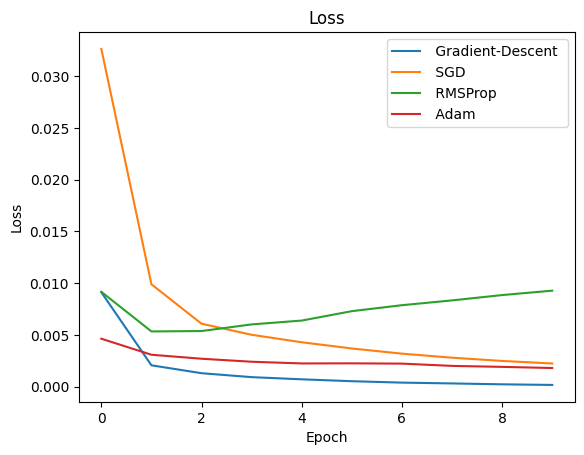

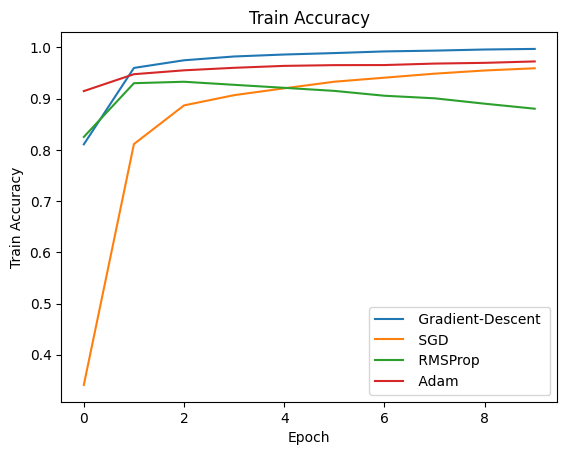

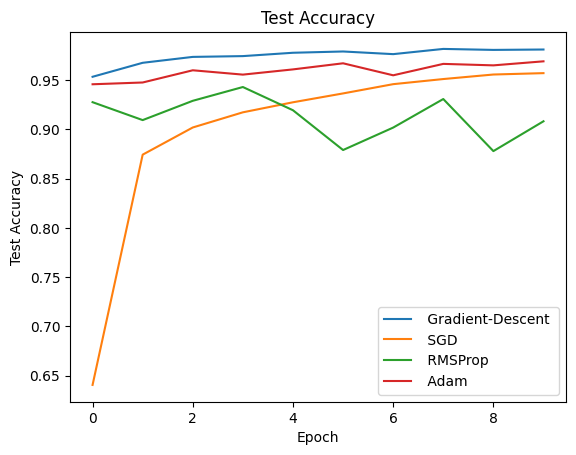

In [12]:
import matplotlib.pyplot as plt
criteria = ["Loss","Train Accuracy","Test Accuracy"]
criteria_ls = [loss_ls, train_acc, test_acc]
for k in range(len(criteria)):
    for i in range(len(name_opt)):
        plt.plot(list(range(0,10)), criteria_ls[k][i], label=name_opt[i])
    plt.xlabel('Epoch')
    plt.ylabel(criteria[k])
    plt.legend()
    plt.title(criteria[k])
    plt.show()


In [13]:
np.savetxt("result/loss.txt",loss_ls,fmt="%s")
np.savetxt("result/train_acc.txt",train_acc,fmt="%s")
np.savetxt("result/test_acc.txt",test_acc,fmt="%s")